In [1]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [2]:
website_df = pd.read_csv("website_data.csv")

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_17260/2812926201.py:1: DtypeWarning: Columns (300,304,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  website_df = pd.read_csv("website_data.csv")


In [3]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv(".env")

client = OpenAI()

In [4]:
categories = [x for x in list(website_df["category"].unique()) if type(x) == str]

In [5]:
import json

categories_response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": """For each string (category name) in the categories, create a classification for it that would work. Produce it in a JSON output as follows:
{
    "classifications": [
        {
            "original_name": "Original name",
            "classification": "your category"
        }
    ]
}


Try to have 10 total classification types. 
"""
        },
        {
            "role": "user",
            "content": "\n".join(categories)
        }
    ],
    model="gpt-4o",
    response_format={"type": "json_object"}
)
categories_response = categories_response.choices[0].message.content
classifications = json.loads(categories_response)["classifications"]



In [6]:
unique_classifications = len(set([x["classification"] for x in classifications]))
print(unique_classifications)

14


In [7]:

# Fuzzy match the categories to the classifications
classification_map = {}
for category in categories:
    best_match = max(classifications, key=lambda x: fuzz.ratio(category, x["original_name"]))
    classification_map[category] = best_match["classification"]
classification_map = {item["original_name"]: item["classification"] for item in classifications}

website_df["classification"] = website_df["category"].map(classification_map)

In [8]:
website_df["classification"].count()

classification_col = website_df["classification"]

In [9]:
selected_cols = reversed([col for col in website_df.columns if col.startswith("1") or col.startswith("2")])
website_df = website_df[selected_cols]

In [10]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

for col in tqdm(website_df.select_dtypes(include=['object']).columns):
    website_df[col] = website_df[col].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /Users/vijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 318/318 [00:22<00:00, 13.89it/s]


In [26]:
import numpy as np

def propagate_str_value_forward(df):
    df = df.copy()
    df.replace('', np.nan, inplace=True)  # Replace empty strings with NaN
    df = df.applymap(lambda x: np.nan if isinstance(x, str) and len(x) < 200 else x)  # Set strings with length < 200 to NaN
    df = df.T.ffill(axis=0).T  # Forward fill NaN values
    df.fillna('', inplace=True)  # Fill remaining NaN with empty strings
    return df

website_df = propagate_str_value_forward(website_df)

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_17260/383312773.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if isinstance(x, str) and len(x) < 200 else x)  # Set strings with length < 200 to NaN
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_17260/383312773.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.T.ffill(axis=0).T  # Forward fill NaN values


In [27]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

normalized_year_scores = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    websites_count = subset.count()

    subset = subset.fillna("")
    subset = subset.astype(str)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        pattern = re.escape(phrase)
        phrase_count[phrase] = subset.str.count(pattern, flags=re.IGNORECASE)

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        phrase_count_sum = website_stats.sum()
        if phrase_count_sum == 0:
            continue
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (website_stats[phrase] / phrase_count_sum - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)

    all_website_scores.append(website_scores)
    normalized_year_scores.append(np.mean(website_scores))
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:01<00:00, 4161.03it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2007
Category Beverages had no websites in year 2007
Category Home Goods had no websites in year 2007
Category Electronics had no websites in year 2007
Year 2007 score: 0.024988620910897708


100%|██████████| 5189/5189 [00:01<00:00, 4022.78it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2008
Category Music & Audio had no websites in year 2008
Category Home Goods had no websites in year 2008
Category Electronics had no websites in year 2008
Year 2008 score: 0.02574593049467876


100%|██████████| 5189/5189 [00:01<00:00, 4045.64it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2009
Category Music & Audio had no websites in year 2009
Category Home Goods had no websites in year 2009
Category Electronics had no websites in year 2009
Year 2009 score: 0.01193208817590687


100%|██████████| 5189/5189 [00:01<00:00, 3817.72it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2010
Category Music & Audio had no websites in year 2010
Category Home Goods had no websites in year 2010
Category Electronics had no websites in year 2010
Year 2010 score: 0.013350551922593771


100%|██████████| 5189/5189 [00:01<00:00, 4019.12it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2011
Category Music & Audio had no websites in year 2011
Category Health & Personal Care had no websites in year 2011
Category Industrial & Manufacturing had no websites in year 2011
Category Home Goods had no websites in year 2011
Category Electronics had no websites in year 2011
Year 2011 score: 0.013500268256768828


100%|██████████| 5189/5189 [00:01<00:00, 4122.08it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2012
Category Beverages had no websites in year 2012
Category Music & Audio had no websites in year 2012
Category Health & Personal Care had no websites in year 2012
Category Industrial & Manufacturing had no websites in year 2012
Category Home Goods had no websites in year 2012
Category Electronics had no websites in year 2012
Year 2012 score: 0.01377456560543527


100%|██████████| 5189/5189 [00:01<00:00, 4079.75it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Fashion Accessories had no websites in year 2013
Category Kitchen & Dining had no websites in year 2013
Category Health & Personal Care had no websites in year 2013
Category Industrial & Manufacturing had no websites in year 2013
Category Home Goods had no websites in year 2013
Category Electronics had no websites in year 2013
Year 2013 score: 0.018232040282149926


100%|██████████| 5189/5189 [00:01<00:00, 4054.85it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Music & Audio had no websites in year 2014
Category Health & Personal Care had no websites in year 2014
Category Industrial & Manufacturing had no websites in year 2014
Category Home Goods had no websites in year 2014
Category Electronics had no websites in year 2014
Year 2014 score: 0.01926090396171727


100%|██████████| 5189/5189 [00:01<00:00, 3832.73it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Beverages had no websites in year 2015
Category Music & Audio had no websites in year 2015
Category Industrial & Manufacturing had no websites in year 2015
Category Home Goods had no websites in year 2015
Category Electronics had no websites in year 2015
Year 2015 score: 0.019903480567580158


100%|██████████| 5189/5189 [00:01<00:00, 3417.94it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Beverages had no websites in year 2016
Category Music & Audio had no websites in year 2016
Category Industrial & Manufacturing had no websites in year 2016
Category Home Goods had no websites in year 2016
Category Electronics had no websites in year 2016
Year 2016 score: 0.022514795440987997


100%|██████████| 5189/5189 [00:01<00:00, 3892.54it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Kitchen & Dining had no websites in year 2017
Category Music & Audio had no websites in year 2017
Category Industrial & Manufacturing had no websites in year 2017
Category Home Goods had no websites in year 2017
Category Electronics had no websites in year 2017
Year 2017 score: 0.04248962336371151


100%|██████████| 5189/5189 [00:01<00:00, 3822.62it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Music & Audio had no websites in year 2018
Category Industrial & Manufacturing had no websites in year 2018
Category Home Goods had no websites in year 2018
Category Electronics had no websites in year 2018
Year 2018 score: 0.04684916300679853


100%|██████████| 5189/5189 [00:01<00:00, 3600.02it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Category Industrial & Manufacturing had no websites in year 2019
Category Home Goods had no websites in year 2019
Year 2019 score: 0.06377737702557235


100%|██████████| 5189/5189 [00:01<00:00, 3625.62it/s]

Category Industrial & Manufacturing had no websites in year 2020
Category Home Goods had no websites in year 2020
Year 2020 score: 0.07333575782207372



/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])

[0.6116318580502269, 0.5990835575645199, 0.21059729777136335, 0.20992731492830044, 0.35741271420598697, 0.3067648966807022, 0.3845774675775446, 0.38738306456337607, 0.2984946840033914, 0.2928051968503427, 0.6141466730760435, 0.6552568917581626, 0.6605604977758384, 0.6460768206090669]


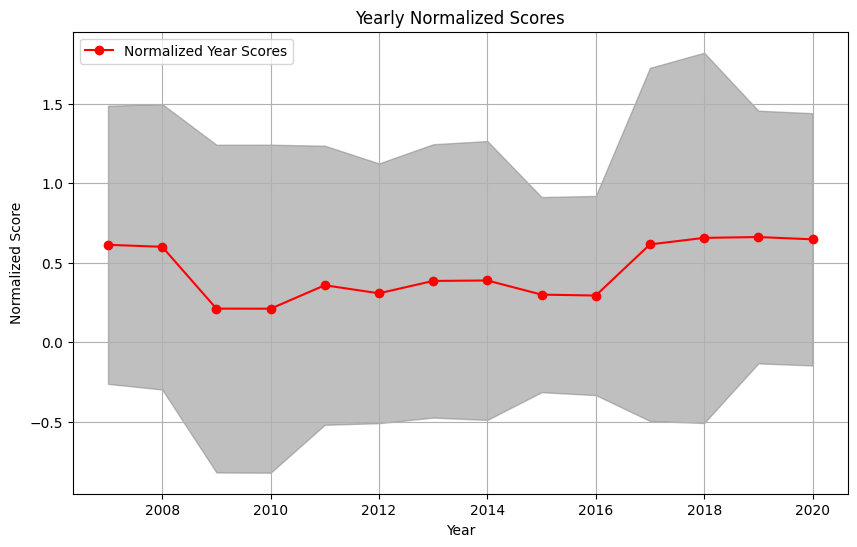

In [31]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

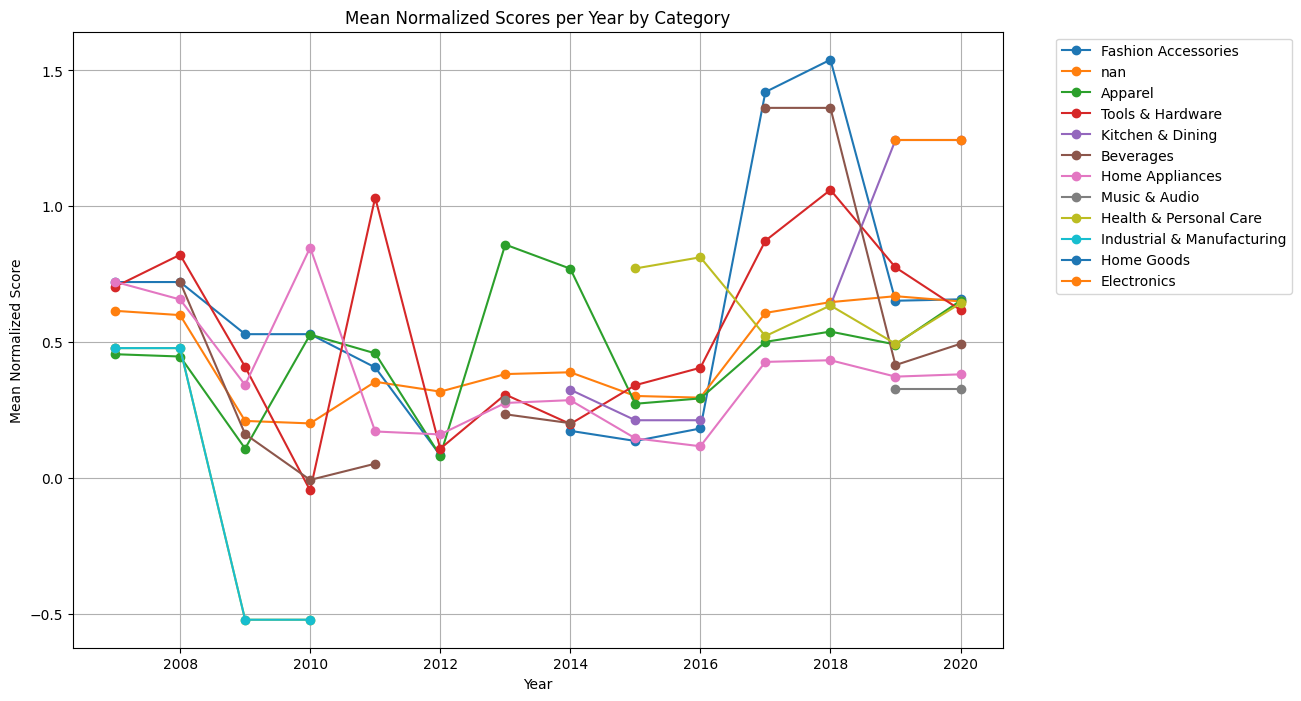

In [30]:
plt.figure(figsize=(12, 8))

for category, scores in categorized_normalized_year_scores.items():
    plt.plot(years, scores, marker='o', label=category)

plt.xlabel('Year')
plt.ylabel('Mean Normalized Score')
plt.title('Mean Normalized Scores per Year by Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [34]:
classification_col.value_counts()

classification
Apparel                       115
Fashion Accessories            87
Tools & Hardware               66
Beverages                      29
Home Appliances                25
Health & Personal Care         18
Kitchen & Dining               10
Music & Audio                   4
Industrial & Manufacturing      3
Home Goods                      2
Electronics                     1
Name: count, dtype: int64